# Seamless Cloning with OpenCV

This notebook demonstrates seamless cloning (Poisson Image Editing) using OpenCV's `seamlessClone` function. Seamless cloning allows for natural-looking image blending by preserving gradients from the source image while maintaining the background from the destination image.

Key features:
- Normal and mixed cloning modes
- Gradient-based blending
- Preserving color transitions
- Handling different image sizes

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET

In [3]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image.

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output size (width, height)

    Returns:
        ndarray: Preprocessed image in BGR format
    """
    # Load image using OpenCV
    img = cv2.imread(image_path)

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LANCZOS4)

    return img


def display_images(images, titles=None, figsize=(15,5)):
    """Display multiple images in a row"""
    n = len(images)

    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

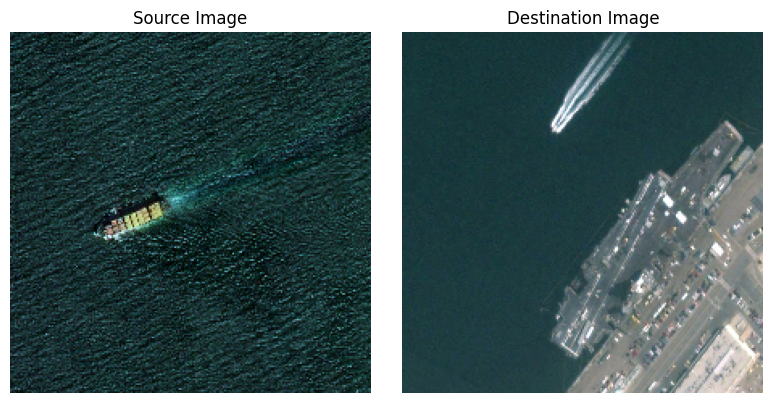

In [4]:
src_path = 'E:/Datasets/MasatiV2/JPEGImages/2000000003.bmp'
dst_path = 'E:/Datasets/MasatiV2/JPEGImages/100001660.bmp'

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
src_image = np.array(load_and_preprocess_image(src_path))
dst_image = np.array(load_and_preprocess_image(dst_path))

axes[0].imshow(src_image)
axes[0].set_title('Source Image')
axes[0].axis('off')

axes[1].imshow(dst_image)
axes[1].set_title('Destination Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Seamless Cloning Process

OpenCV's seamless cloning operates in the following steps:
1. Load source and destination images
2. Create a binary mask for the source image
3. Specify the location for blending
4. Apply seamless cloning using one of two modes:
   - NORMAL_CLONE: Preserves gradients from source image
   - MIXED_CLONE: Combines gradients from both images

The quality of results depends on:
- Mask accuracy
- Position of blending
- Color compatibility between images
- Image resolution and sizes

In [15]:
def seamless_clone(src_path, dst_path, mask, mode):
    # Load images
    src = load_and_preprocess_image(src_path)
    dst = load_and_preprocess_image(dst_path)

    # Validate image sizes
    if src.shape[:2] != mask.shape[:2]:
        raise ValueError("Source image and mask must have same dimensions")

    # Calculate random center position with margins
    margin = 50  # Safe margin from edges
    center = (
        np.random.randint(margin, dst.shape[1] - margin),
        np.random.randint(margin, dst.shape[0] - margin)
    )

    # Perform seamless cloning
    result = cv2.seamlessClone(
        src, dst, mask, center,
        flags=mode,
    )

    return src, dst, result

In [6]:
def parse_voc_xml(xml_path):
    """
    Parse PASCAL VOC annotation XML file.

    Args:
        xml_path (str): Path to XML annotation file

    Returns:
        tuple: (list of bounding boxes, list of class labels)
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    class_labels = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
        class_labels.append(name)

    return boxes, class_labels

In [7]:
def create_mask_from_bbox(image_shape, xml_path, original_size, target_size):
    """
    Create a binary mask from bounding boxes found in the XML file,
    adjusting for resized coordinates.

    Args:
        image_shape (tuple): Shape of the mask (height, width).
        xml_path (str): Path to the XML file containing bounding box coordinates.
        original_size (tuple): Original dimensions of the image (width, height).
        target_size (tuple): Target dimensions of the image after resizing (width, height).

    Returns:
        np.ndarray: Binary mask with bounding box areas marked.
    """
    # Initialize the mask with zeros
    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Parse the bounding boxes and class labels from the XML file
    boxes, _ = parse_voc_xml(xml_path)

    # Calculate scaling factors
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    # Loop through each bounding box
    for box in boxes:
        # Extract coordinates from the bounding box
        xmin, ymin, xmax, ymax = box

        # Scale the coordinates to match the target size
        xmin = int(xmin * scale_x)
        ymin = int(ymin * scale_y)
        xmax = int(xmax * scale_x)
        ymax = int(ymax * scale_y)

        # Fill the corresponding area in the mask with 255 (white)
        mask[ymin:ymax, xmin:xmax] = 255

    return mask

In [8]:
def get_image_dimensions(image_path):
    """
    Get image dimensions efficiently using PIL.

    Args:
        image_path (str): Path to the image file

    Returns:
        tuple: (width, height) of the image
    """
    with Image.open(image_path) as img:
        return img.size  # Returns (width, height)


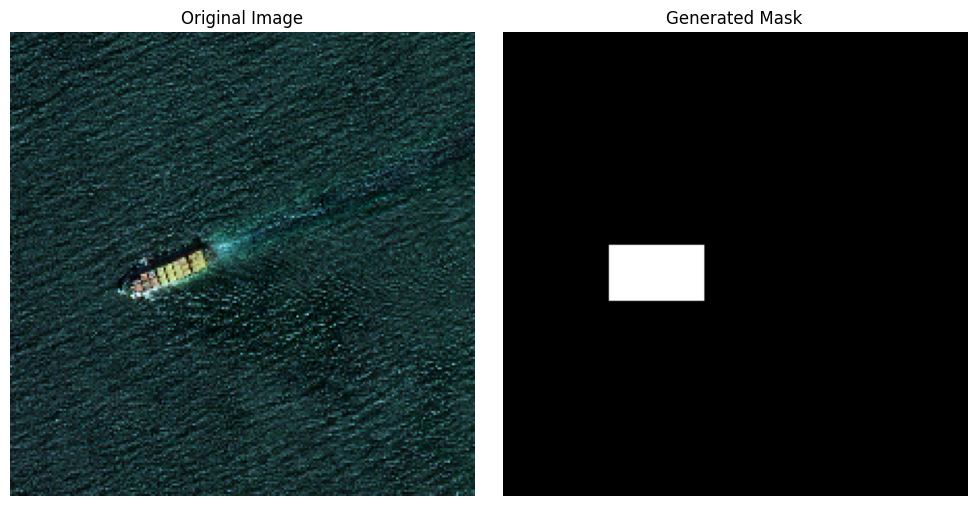

In [9]:
xml_path = "E:/Datasets/MasatiV2/Annotations/2000000003.xml"
image_shape = src_image.shape

# Generate binary mask from XML
mask = create_mask_from_bbox(image_shape, xml_path, original_size = get_image_dimensions(src_path), target_size = (224, 224))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
ax1.imshow(src_image)
ax1.set_title('Original Image')
ax1.axis('off')

# Display the mask
ax2.imshow(mask, cmap='gray')
ax2.set_title('Generated Mask')
ax2.axis('off')

plt.tight_layout()
plt.show()


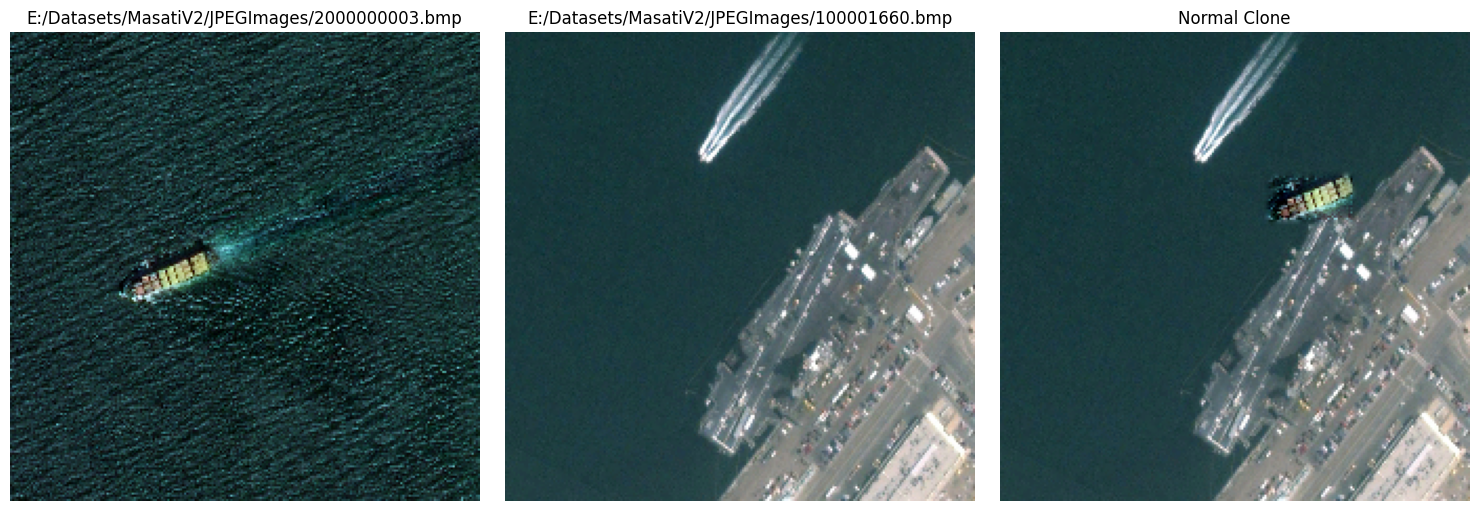

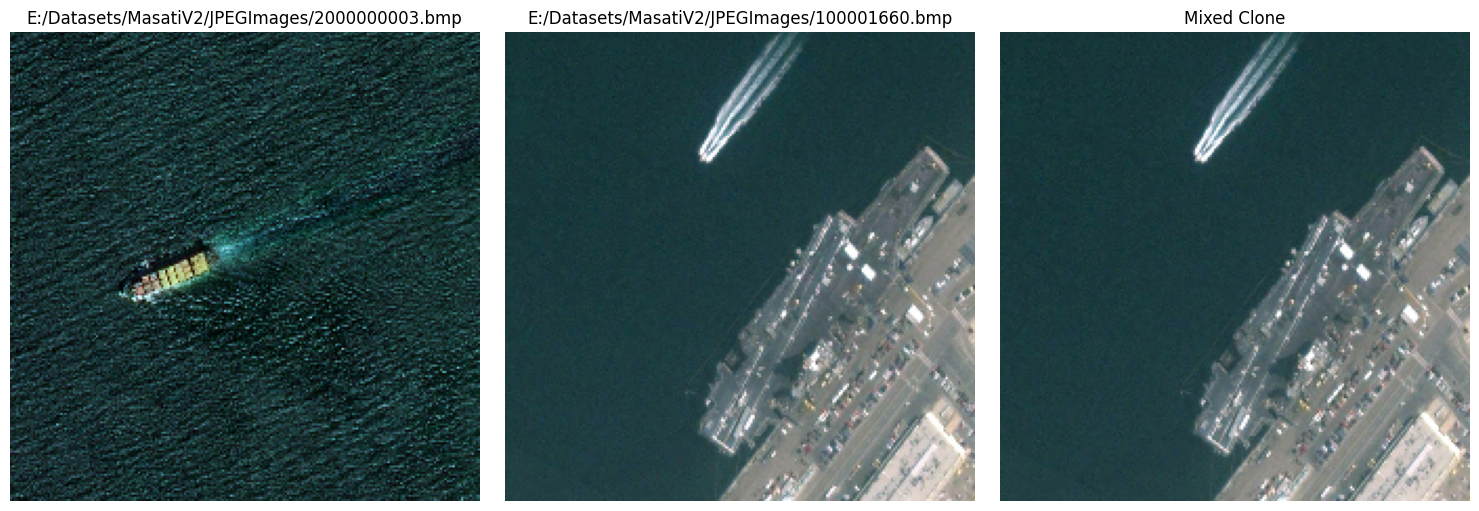

In [10]:
# Normal clone
normal_results = seamless_clone(
    src_path, dst_path, mask,
    mode=cv2.NORMAL_CLONE
)

display_images(
    normal_results,
    [src_path, dst_path, "Normal Clone"],
    figsize=(15,5)
)

# Mixed clone
mixed_results = seamless_clone(
    src_path, dst_path, mask,
    mode=cv2.MIXED_CLONE
)

display_images(
    mixed_results,
    [src_path, dst_path, "Mixed Clone"],
    figsize=(15,5)
)